![BTS](https://github.com/vfp1/bts-dsf-2020/blob/main/Logo-BTS.jpg?raw=1)

# Classical Data Analysis
## Supervised Learning - Logistic Regression Analysis
### by Ennio Maldonado

### Imports and set up
---

In [ ]:
import os
import re
import gc 
from tqdm import tqdm
from datetime import date     
from datetime import datetime 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np 
import pandas as pd 
from sklearn.model_selection import GridSearchCV , train_test_split
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import accuracy_score , f1_score , recall_score, precision_score, make_scorer
from sklearn.preprocessing import StandardScaler,OneHotEncoder , LabelEncoder ,normalize

# Jedi not working
%config Completer.use_jedi = False

### Dataset
---
https://www.kaggle.com/sneharshinde/ltfs-av-data

The dataset is for vehicle loan default prediction where we need to predict the customer who will default for paying the EMI. The data is almost clean and easy to understand.
Financial institutions incur significant losses due to the default of vehicle loans. This has led to the tightening up of vehicle loan underwriting and increased vehicle loan rejection rates. The need for a better credit risk scoring model is also raised by these institutions. This warrants a study to estimate the determinants of vehicle loan default. A financial institution has hired you to accurately predict the probability of loanee/borrower defaulting on a vehicle loan in the first EMI (Equated Monthly Instalments) on the due date. Following Information regarding the loan and loanee are provided in the datasets:

Loanee Information (Demographic data like age, Identity proof etc.)

Loan Information (Disbursal details, loan to value ratio etc.)

Bureau data & history (Bureau score, number of active accounts, the status of other loans, credit history etc.)

Doing so will ensure that clients capable of repayment are not rejected and important determinants can be identified which can be further used for minimising the default rates.


### Data loading
---

In [ ]:
# Load data
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test_bqCt9Pv.csv')

In [3]:
# Quick check
train.head()

,UniqueID,disbursed_amount,asset_cost,ltv,branch_id,supplier_id,manufacturer_id,Current_pincode_ID,Date.of.Birth,Employment.Type,...,SEC.SANCTIONED.AMOUNT,SEC.DISBURSED.AMOUNT,PRIMARY.INSTAL.AMT,SEC.INSTAL.AMT,NEW.ACCTS.IN.LAST.SIX.MONTHS,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,AVERAGE.ACCT.AGE,CREDIT.HISTORY.LENGTH,NO.OF_INQUIRIES,loan_default
0,420825,50578,58400,89.55,67,22807,45,1441,01-01-84,Salaried,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0
1,537409,47145,65550,73.23,67,22807,45,1502,31-07-85,Self employed,...,0,0,1991,0,0,1,1yrs 11mon,1yrs 11mon,0,1
2,417566,53278,61360,89.63,67,22807,45,1497,24-08-85,Self employed,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0
3,624493,57513,66113,88.48,67,22807,45,1501,30-12-93,Self employed,...,0,0,31,0,0,0,0yrs 8mon,1yrs 3mon,1,1
4,539055,52378,60300,88.39,67,22807,45,1495,09-12-77,Self employed,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,1,1


## Initial Data Exploration
---------------

In [4]:
# Sanity check
train.describe()

,UniqueID,disbursed_amount,asset_cost,ltv,branch_id,supplier_id,manufacturer_id,Current_pincode_ID,State_ID,Employee_code_ID,...,SEC.OVERDUE.ACCTS,SEC.CURRENT.BALANCE,SEC.SANCTIONED.AMOUNT,SEC.DISBURSED.AMOUNT,PRIMARY.INSTAL.AMT,SEC.INSTAL.AMT,NEW.ACCTS.IN.LAST.SIX.MONTHS,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,NO.OF_INQUIRIES,loan_default
count,233154.000000,233154.000000,2.331540e+05,233154.000000,233154.000000,233154.000000,233154.000000,233154.000000,233154.000000,233154.000000,...,233154.000000,2.331540e+05,2.331540e+05,2.331540e+05,2.331540e+05,2.331540e+05,233154.000000,233154.000000,233154.000000,233154.000000
mean,535917.573376,54356.993528,7.586507e+04,74.746530,72.936094,19638.635035,69.028054,3396.880247,7.262243,1549.477148,...,0.007244,5.427793e+03,7.295923e+03,7.179998e+03,1.310548e+04,3.232684e+02,0.381833,0.097481,0.206615,0.217071
std,68315.693711,12971.314171,1.894478e+04,11.456636,69.834995,3491.949566,22.141304,2238.147502,4.482230,975.261278,...,0.111079,1.702370e+05,1.831560e+05,1.825925e+05,1.513679e+05,1.555369e+04,0.955107,0.384439,0.706498,0.412252
min,417428.000000,13320.000000,3.700000e+04,10.030000,1.000000,10524.000000,45.000000,1.000000,1.000000,1.000000,...,0.000000,-5.746470e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000
25%,476786.250000,47145.000000,6.571700e+04,68.880000,14.000000,16535.000000,48.000000,1511.000000,4.000000,713.000000,...,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000
50%,535978.500000,53803.000000,7.094600e+04,76.800000,61.000000,20333.000000,86.000000,2970.000000,6.000000,1451.000000,...,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000
75%,595039.750000,60413.000000,7.920175e+04,83.670000,130.000000,23000.000000,86.000000,5677.000000,10.000000,2362.000000,...,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,1.999000e+03,0.000000e+00,0.000000,0.000000,0.000000,0.000000
max,671084.000000,990572.000000,1.628992e+06,95.000000,261.000000,24803.000000,156.000000,7345.000000,22.000000,3795.000000,...,8.000000,3.603285e+07,3.000000e+07,3.000000e+07,2.564281e+07,4.170901e+06,35.000000,20.000000,36.000000,1.000000


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 233154 entries, 0 to 233153
Data columns (total 41 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   UniqueID                             233154 non-null  int64  
 1   disbursed_amount                     233154 non-null  int64  
 2   asset_cost                           233154 non-null  int64  
 3   ltv                                  233154 non-null  float64
 4   branch_id                            233154 non-null  int64  
 5   supplier_id                          233154 non-null  int64  
 6   manufacturer_id                      233154 non-null  int64  
 7   Current_pincode_ID                   233154 non-null  int64  
 8   Date.of.Birth                        233154 non-null  object 
 9   Employment.Type                      225493 non-null  object 
 10  DisbursalDate                        233154 non-null  object 
 11  State_ID     

In [6]:
# Any nulls fellas?
train.isnull().sum()

UniqueID                                  0
disbursed_amount                          0
asset_cost                                0
ltv                                       0
branch_id                                 0
supplier_id                               0
manufacturer_id                           0
Current_pincode_ID                        0
Date.of.Birth                             0
Employment.Type                        7661
DisbursalDate                             0
State_ID                                  0
Employee_code_ID                          0
MobileNo_Avl_Flag                         0
Aadhar_flag                               0
PAN_flag                                  0
VoterID_flag                              0
Driving_flag                              0
Passport_flag                             0
PERFORM_CNS.SCORE                         0
PERFORM_CNS.SCORE.DESCRIPTION             0
PRI.NO.OF.ACCTS                           0
PRI.ACTIVE.ACCTS                

In [7]:
# Closer look at feature with empty values
train['Employment.Type'].value_counts()

Self employed    127635
Salaried          97858
Name: Employment.Type, dtype: int64

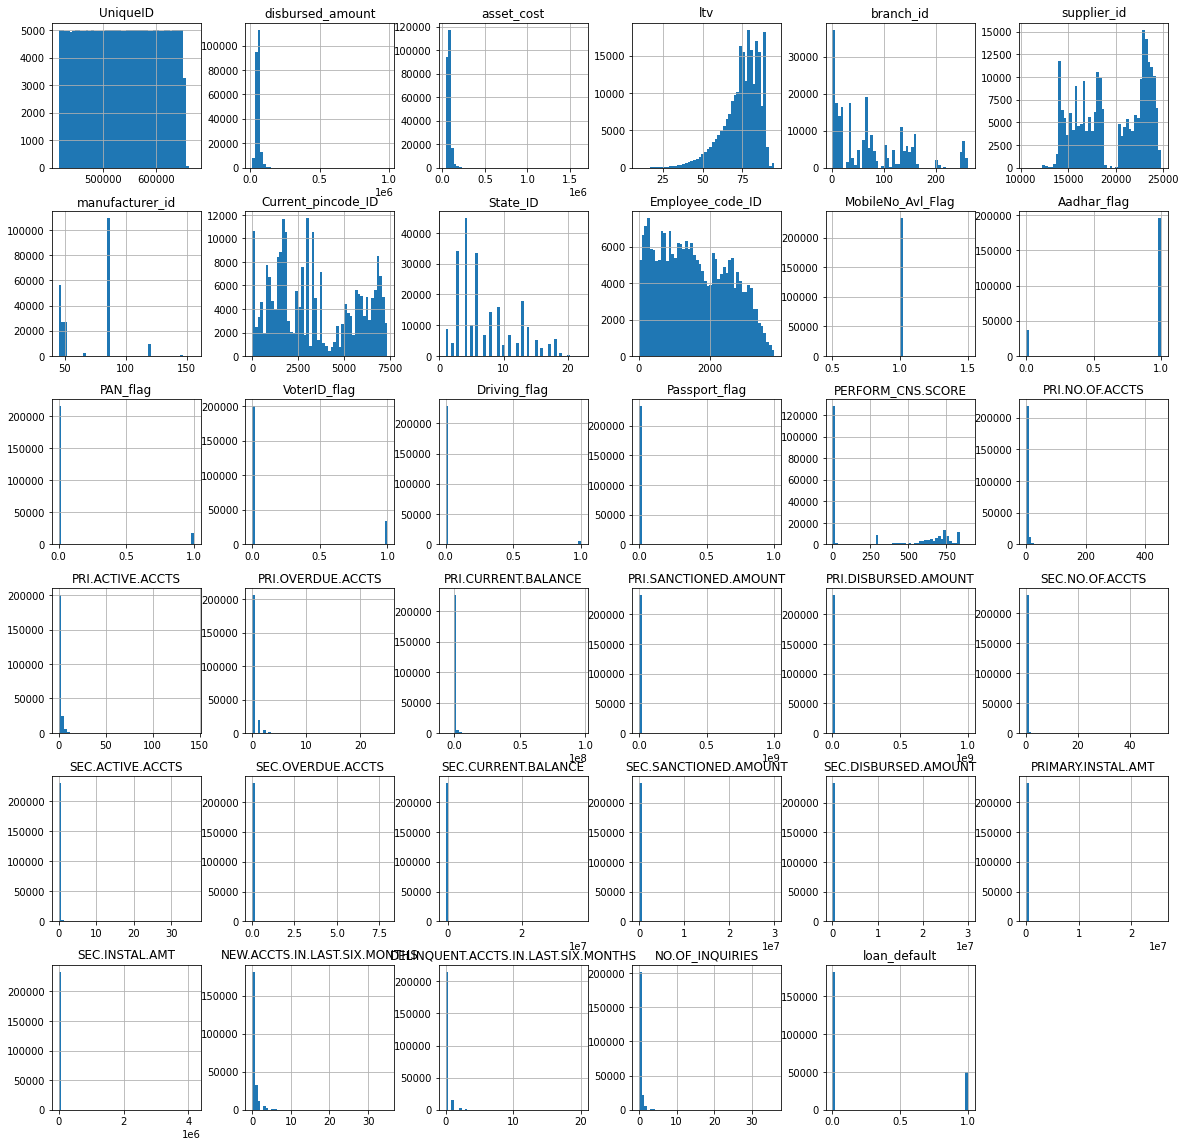

In [8]:
train.hist(bins=50,figsize=(20,20))
plt.show()

In [9]:
# Categorical variables - how many classes per feature?
train.select_dtypes("object").nunique()

Date.of.Birth                    15433
Employment.Type                      2
DisbursalDate                       84
PERFORM_CNS.SCORE.DESCRIPTION       20
AVERAGE.ACCT.AGE                   192
CREDIT.HISTORY.LENGTH              294
dtype: int64

#### So many classes per category...for Date of birth we can define AGE, and for PERFORM_CNS.SCORE.DESCRIPTION is possible to define some bins, the other three are just too convoluted to be of any significance, so I decided to drop them.

In [10]:
#PREPROCESSING FOR LATER USE IN DEPLOYMENT

  
# CODE FOR AGE CONVERSION: https://www.geeksforgeeks.org/python-program-to-calculate-age-in-year/
def calcAge(born):
    born = datetime.strptime(born , '%d-%m-%y')
    today= date.today()
    age = today.year- born.year - ((today.month,today.day) < (born.month,born.day))
    return age


# https://www.kaggle.com/matthieu64/car-loan-default-prediction/notebook#Feature-Engineering
def removeOutlier(df, cols):
    indexes=[]
    for col in tqdm(cols):
        if (df[col].dtypes !='object'):
            Q1 = df[col].quantile(q=0.001)
            Q3 = df[col].quantile(q=0.999)        
            for i in (df.index):
                if ((df.loc[i,col]< Q1/5) or (df.loc[i,col] > 5*Q3)):
                    df = df.drop(index=i)
                    indexes.append(i)
    return df, indexes


def preprocessing(df):
    not_scored = ['Not Scored: More than 50 active Accounts found', 
     'Not Scored: No Activity seen on the customer (Inactive)',
     'Not Scored: No Updates available in last 36 months',
     'Not Enough Info available on the customer','Not Scored: Only a Guarantor',
     'Not Scored: Sufficient History Not Available',
     'Not Scored: Not Enough Info available on the customer']
    # Fill NaN with most frequent values
    df = train.fillna(df.mode().iloc[0])
    # Drop cat_col with too much variables
    df.drop(['DisbursalDate' , 'AVERAGE.ACCT.AGE', 'CREDIT.HISTORY.LENGTH'], inplace=True , axis=1)
        
    # Bins 
    df['PERFORM_CNS.SCORE.DESCRIPTION'].replace(to_replace=not_scored, value= 'Not Scored', inplace = True)
    
    #Transfro date of birth into age
    dob = df['Date.of.Birth']
    df['Age'] = dob.map(calcAge)
    df.drop(['Date.of.Birth'] , axis=1 , inplace=True)
    
    # Remove outliers based on IQR
    cols_with_outliers=['disbursed_amount', 'asset_cost', 'PRI.NO.OF.ACCTS', 'PRI.ACTIVE.ACCTS','PRI.OVERDUE.ACCTS','PRI.CURRENT.BALANCE', 'PRI.SANCTIONED.AMOUNT','PRI.SANCTIONED.AMOUNT',
       'PRI.DISBURSED.AMOUNT', 'SEC.NO.OF.ACCTS', 'SEC.ACTIVE.ACCTS','SEC.CURRENT.BALANCE', 'SEC.SANCTIONED.AMOUNT',
       'SEC.DISBURSED.AMOUNT', 'PRIMARY.INSTAL.AMT', 'SEC.INSTAL.AMT',
       'NEW.ACCTS.IN.LAST.SIX.MONTHS', 'DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS', 'NO.OF_INQUIRIES','Employment.Type', 'PERFORM_CNS.SCORE.DESCRIPTION']
    
    clean_df, indexex = removeOutlier(df , cols_with_outliers)
    
    #separate target variable
    x = clean_df.drop(['loan_default'],axis=1)
    
    # Dummy variables (onehot encoding)
    cat_data= x.select_dtypes(include='object').columns
    cat_x = pd.get_dummies(x[cat_data])
    
    # Scaling Data sklearn
    num_data = list(x._get_numeric_data().columns)
    scaler = StandardScaler()
    scaler.fit(x[num_data])
    normalized = scaler.transform(x[num_data])
    normalized_x = pd.DataFrame(normalized , columns=num_data)    
    
    # Concatenating cat data with scaled num data
    x_final = pd.concat([normalized_x , cat_x], sort=True , axis=1)
    
    # Drop the NaN after all this process
    x_final = x_final.dropna(axis=0)
    y_final = clean_df['loan_default'].iloc[x_final.index]
    
    return x_final, y_final

In [11]:
x_train, y_train = preprocessing(train)
x_test, y_test = preprocessing(test)

100%|██████████| 21/21 [01:35<00:00,  4.53s/it]


In [12]:
# Feature Engineering

# Finding Correlation between features
def correlation(df ,column):
    dff= df.join(column)
    corr_max = dff.corr()  #create correlation matrix
    top_15 = corr_max.nlargest(20 , 'loan_default')['loan_default'].index # select top 15 correlate features
    corr = np.corrcoef(dff[top_15].values.T)    
    return corr , top_15

#Plot correlation map
def plot_heatmap(corr,top_15):
    plt.figure(figsize=(15,10))
    sns.heatmap(corr, cbar=True , annot=True , fmt='.2f', yticklabels=top_15.values , xticklabels=top_15.values)
    plt.title('CORRELATION MATRIX')
    plt.show()
    

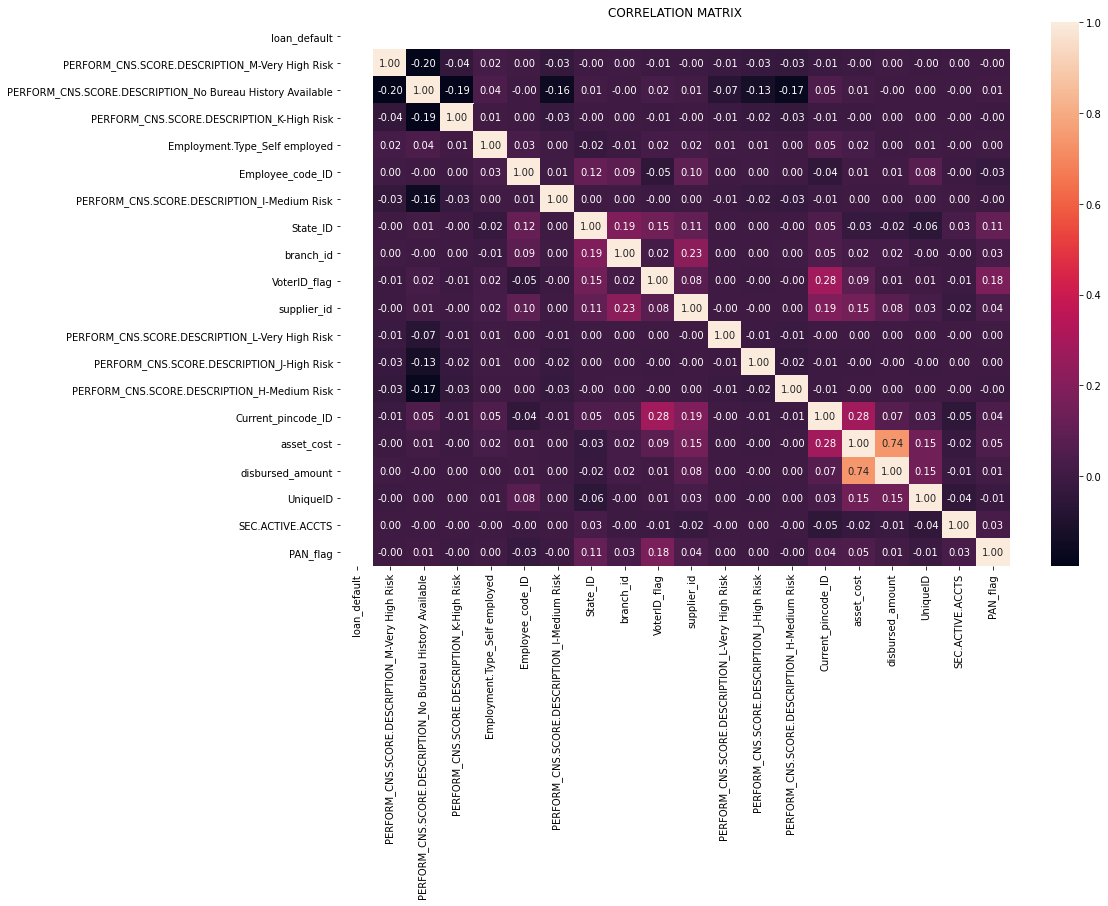

In [13]:
corr , top_15 = correlation(x_train, y_train)

plot_heatmap(corr, top_15)

In [14]:
# Model Training
c= [0.001 ,0.0001,0.01,1,10]
scores=[]
for i in (c):
    lr = LogisticRegression(penalty='l1' , solver='liblinear' , max_iter=1000 , C=i)
    lr.fit(x_train,y_train)
    scores.append(lr.score(x_test,y_test))
print("The score for C= {} is {}".format(scores.index(max(scores)),max(scores)))


The score for C= 1 is 0.7828101850256693


THE END